# Imports


In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.preprocessing import sequence
from tensorflow.python.keras import Sequential
from keras.models import load_model
from tensorflow.python.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import pickle

from keras import preprocessing
import keras
from keras.utils import pad_sequences

from tensorflow import keras
from tensorflow.keras import layers

In [136]:
df = pd.read_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\neural_network_data.csv')

In [137]:
df['rating'] = df['rating'].fillna((df['rating'].mean()))
df['rating'] = df['rating'].astype(np.int64)
df['review'] = df['review'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16511 entries, 0 to 16510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  16511 non-null  int64 
 1   review  16511 non-null  object
dtypes: int64(1), object(1)
memory usage: 258.1+ KB


# One Hot Encoding Scores Column

Veri setimiz model kurmaya uygun olmadığından ve 1 ila 5 arasında puan çıktısına sahip olmak açısından one hot encoding uygulamak istedim.

In [138]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['rating']]).toarray())

df = df.join(enc_df)
df = df.rename(columns={0: "rating_1", 1:'rating_2',2:'rating_3',3:'rating_4',4:'rating_5'})
df.head()

,rating,review,rating_1,rating_2,rating_3,rating_4,rating_5
0,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


# Train - Test Split

In [139]:
x_train, x_test, y_train, y_test = train_test_split(df[['review']], 
                                                    df[['rating_1','rating_2','rating_3','rating_4','rating_5']],
                                                    test_size=.2, 
                                                    random_state=42)

Başka modeller deneyebilmek için yaptığım train test splitini ayrıyetten kaydetmek istedim.

In [140]:
y_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\y_test_neural.csv',index=False)

In [141]:
x_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\x_test_neural.csv')

In [142]:
y_train.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\y_train_neural.csv')
x_train.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\x_train_neural.csv')

#   Noktalama işaretlerini Kaldırılması ve Tokanization Yapılması

In [143]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

def text_cleanup(text):

    token_list = tokenizer.tokenize(text.lower())
    new_text = ''
    for word in token_list:
        new_text += word + ' '

    return new_text

In [144]:
x_train['review_cleaned'] = x_train['review'].apply(text_cleanup)
x_test['review_cleaned'] = x_test['review'].apply(text_cleanup)

In [145]:
review_index = 2000
print('REVİEW:', x_train['review'].iloc[review_index],)
print('REVİEW_CLEANED', x_train['review_cleaned'].iloc[review_index])

REVİEW: booking did not happen booked hotel trip advisor suggestion, sent visa number confirmation arrived did not booking alternative accom arrived home deducted visa account sent email far not reply, currently trying recover funds bank, definatly not advise using hotel, went hotel colon fantastic, cheryl wilsmore,  
REVİEW_CLEANED booking did not happen booked hotel trip advisor suggestion sent visa number confirmation arrived did not booking alternative accom arrived home deducted visa account sent email far not reply currently trying recover funds bank definatly not advise using hotel went hotel colon fantastic cheryl wilsmore 


In [146]:
x_train.head()

,review,review_cleaned
13105,honeymoon dominican looking reasonably priced ...,honeymoon dominican looking reasonably priced ...
5714,"I was lucky to be upgraded on check -in , bein...",i was lucky to be upgraded on check in being a...
16385,home away home staying hotel trip paris 1981 p...,home away home staying hotel trip paris prior ...
5028,This Hilton hotel has a good location in the h...,this hilton hotel has a good location in the h...
7132,"A great place to stay if visiting Maida Vale, ...",a great place to stay if visiting maida vale s...


# Her bir kelimenin flat şekilde ayrılması

In [147]:
flat_review = " ".join(x_train['review_cleaned'].values)
flat_review = flat_review.lower().split()

In [148]:
#flat_review

In [149]:
len(flat_review)

1375224

Aynı kelimelerin tamamen kaldırıp uniqe bir veri oluşturulması

In [150]:
unique_list = []
for word in flat_review:
    if word not in unique_list:
        unique_list.append(word)

In [151]:
len(unique_list)

30894

In [152]:
word_index_dict = {}
for i in range(0,len(unique_list)):
    word_index_dict[unique_list[i]] = i

In [153]:
 #word_index_dict

In [154]:
#word_index_dict.items()

In [155]:
word_index_dict = {k:(v+4) for k,v in word_index_dict.items()}
word_index_dict['<PAD>'] = 0
word_index_dict['<START>'] = 1
word_index_dict['<UNK>'] = 2  #Unkown Words
word_index_dict['<UNUSED>'] = 3

In [156]:
len(word_index_dict)

30898

# Indexing Words in Reviews Using Dictionary

In [157]:
def index_review_words(text):
    review_word_list = []
    for word in text.lower().split():
        if word in word_index_dict.keys():
            review_word_list.append(word_index_dict[word])
        else:
            review_word_list.append(word_index_dict['<UNK>'])

    return review_word_list

In [158]:
x_train['preprocessed_review'] = x_train['review_cleaned'].apply(index_review_words)
x_test['preprocessed_review'] = x_test['review_cleaned'].apply(index_review_words)

In [159]:
x_train.head()

,review,review_cleaned,preprocessed_review
13105,honeymoon dominican looking reasonably priced ...,honeymoon dominican looking reasonably priced ...,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
5714,"I was lucky to be upgraded on check -in , bein...",i was lucky to be upgraded on check in being a...,"[40, 118, 119, 120, 121, 122, 123, 124, 125, 1..."
16385,home away home staying hotel trip paris 1981 p...,home away home staying hotel trip paris prior ...,"[206, 207, 206, 208, 209, 210, 211, 212, 213, ..."
5028,This Hilton hotel has a good location in the h...,this hilton hotel has a good location in the h...,"[249, 250, 209, 251, 48, 15, 218, 125, 93, 252..."
7132,"A great place to stay if visiting Maida Vale, ...",a great place to stay if visiting maida vale s...,"[48, 26, 216, 120, 113, 316, 317, 318, 319, 23..."


In [160]:
x_train['preprocessed_review'].describe()

count       13208
unique      13207
top       [23127]
freq            2
Name: preprocessed_review, dtype: object

In [161]:
x_train['preprocessed_review'].shape

(13208,)

In [162]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train['preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=1000)  #value=0
x_test = pad_sequences(x_test['preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=1000)

In [163]:
x_train.shape

(13208, 1000)

# Creating Neural Network Model

In [164]:
np.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\x_test',x_test)

In [165]:
y_train.shape

(13208, 5)

In [166]:
x_test.shape

(3303, 1000)

In [167]:
y_test.shape

(3303, 5)

In [168]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.2,random_state=42)

In [169]:
##
unique_list_len = len(word_index_dict)
##
model = Sequential()
model.add(Embedding(unique_list_len,128))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))


##
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
#spars_categ.. #
###
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=250,
    validation_data=(x_val,y_val),)
###


Epoch 1/20
43/43 [==============================] - 5s 107ms/step - loss: 1.6094 - accuracy: 0.2028 - val_loss: 1.6089 - val_accuracy: 0.1877
Epoch 2/20
43/43 [==============================] - 4s 98ms/step - loss: 1.6062 - accuracy: 0.2309 - val_loss: 1.6051 - val_accuracy: 0.2945
Epoch 3/20
43/43 [==============================] - 4s 103ms/step - loss: 1.5974 - accuracy: 0.2740 - val_loss: 1.5892 - val_accuracy: 0.3002
Epoch 4/20
43/43 [==============================] - 5s 108ms/step - loss: 1.5668 - accuracy: 0.3155 - val_loss: 1.5425 - val_accuracy: 0.3149
Epoch 5/20
43/43 [==============================] - 4s 99ms/step - loss: 1.4924 - accuracy: 0.3495 - val_loss: 1.4591 - val_accuracy: 0.3539
Epoch 6/20
43/43 [==============================] - 5s 108ms/step - loss: 1.3828 - accuracy: 0.4074 - val_loss: 1.3413 - val_accuracy: 0.4111
Epoch 7/20
43/43 [==============================] - 4s 102ms/step - loss: 1.2643 - accuracy: 0.4637 - val_loss: 1.2477 - val_accuracy: 0.4682
Epoch 8/

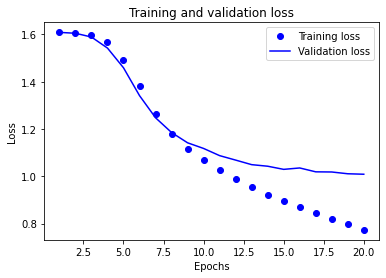

In [170]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
history_dict = history.history

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

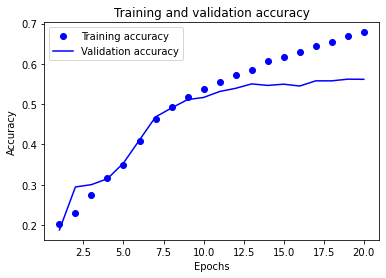

In [171]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Test Confusion Matrix

Reverse Encode Target Into One Column for Confusion Matrix

In [172]:
def reverse_encode(y_df):

    y_df['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)
    for i in range(0,len(y_df)):
        if y_df.iloc[i,-1] == 'score_1':
            y_df.iloc[i,-1] = 1
        elif y_df.iloc[i,-1] == 'score_2':
            y_df.iloc[i,-1] = 2
        elif y_df.iloc[i,-1]== 'score_3':
            y_df.iloc[i,-1] = 3
        elif y_df.iloc[i,-1]== 'score_4':
            y_df.iloc[i,-1] = 4
        elif y_df.iloc[i,-1] == 'score_5':
            y_df.iloc[i,-1]= 5

In [173]:
yy_test = y_test
yy_val = y_val

reverse_encode(yy_test)
reverse_encode(yy_val)

In [174]:
def add_one_argmax_score(x):

    x = x+1

    return x

In [175]:
yy_test_predicted = add_one_argmax_score(np.argmax(model.predict(x_test),axis=1))

 Saving Neural Network Preprocessed y Data

In [176]:
yy_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/y_test_nn_df_5labels.csv',index=False)
np.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/y_test_predicted_array_5labels',yy_test_predicted)

In [177]:
yy_test['score'] = yy_test['score'].replace(['rating_1'],1)
yy_test['score'] = yy_test['score'].replace(['rating_2'],2)
yy_test['score'] = yy_test['score'].replace(['rating_3'],3)
yy_test['score'] = yy_test['score'].replace(['rating_4'],4)
yy_test['score'] = yy_test['score'].replace(['rating_5'],5)

In [178]:
yy_test['score'] = yy_test['score'].astype(np.int64)

In [179]:
def conf_matrix(cm):

    plt.figure(figsize=(9,9))
    ax = sns.heatmap(cm,
                     annot= True,
                     fmt = '.4g',
                     cbar=0,
                     xticklabels=[1,2,3,4,5],
                     yticklabels=[1,2,3,4,5])

    plt.show()

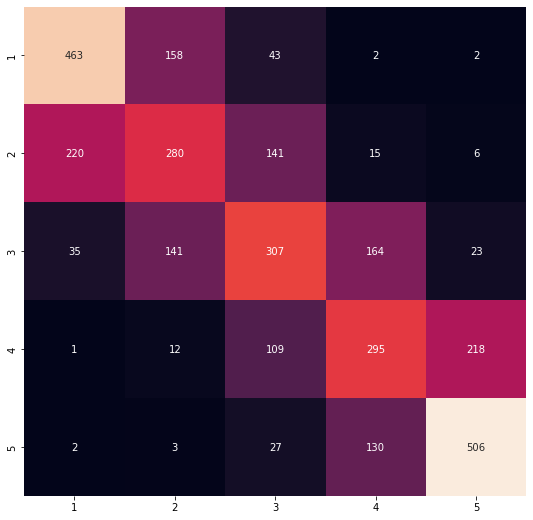

In [185]:
test_cm = confusion_matrix(yy_test['score'], yy_test_predicted)
conf_matrix(test_cm)

In [186]:
from sklearn.metrics import classification_report

print(classification_report(yy_test_predicted, yy_test['score']))

              precision    recall  f1-score   support

           1       0.69      0.64      0.67       721
           2       0.42      0.47      0.45       594
           3       0.46      0.49      0.47       627
           4       0.46      0.49      0.48       606
           5       0.76      0.67      0.71       755

    accuracy                           0.56      3303
   macro avg       0.56      0.55      0.55      3303
weighted avg       0.57      0.56      0.57      3303



# Saving Model for streamlit

In [187]:
model.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/Models/Neural_Network.h5')

In [188]:
pickle.dump(word_index_dict,open(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/Models/word_index_dict.pkl','wb'))